## RL blood matching

<p> Start off using only the 3 major antigens: A,B and D. </p>

In [9]:
import pandas as pd
import numpy as np
import glob
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [11]:
# Reads results csv files into df
def read_csv(path):
    csv_files = glob.glob(path + "/*.csv")
    df_list = (pd.read_csv(file) for file in csv_files)
    full_df = pd.concat(df_list, ignore_index=True)
    full_df.columns = [c.replace(' ', '_') for c in full_df.columns]
    return full_df

In [134]:
# Separates and plots rewards
r_disc = -11 # reward for discarded product
def plot_reward(df, r_nex, lr = None):
    # Multiple number of nonexistent issues by r_nex
    reward_nex = r_nex * df['issued_but_nonexistent']
    # Reward for issued but discarded
    reward_disc = r_disc * df['issued_but_discarded']

    # Remaining reward
    reward_rem = df['reward'] - reward_disc - reward_nex

    plt.plot(savgol_filter(reward_disc, window_length=200, polyorder=2), label='discarded')
    plt.plot(savgol_filter(reward_rem, window_length=200, polyorder=2), label='good')
    plt.plot(savgol_filter(reward_nex, window_length=200, polyorder=2), label='non existing')

    plt.legend(loc="lower right")

    plt.xlabel('Timesteps')
    plt.ylabel('Reward')
    plt.title("Epsilon-decay = " + str(lr))

    plt.show()

### Network architecture
#### Input size

```
input_size = len(np.ravel(self.env.state))

# state dimension = 8 x 44
# 8:    number of blood groups
# 44:   max age (35) + max lead time (9)

input size = 8 * 44 = 352
```
#### Output size
```
output_size = self.env.action_space.shape[0]
# equal to number of actions: 8
```
#### Model
```
input -> [8, relu] -> [64, tanh] -> [32, tanh] -> [output, sigmoid]
```

### 1 Learning rate tests

Several tests with varying learning rates and the above NN architecture.
Reward for non-existing products is set to -60.

In [123]:
path_a01 = r'results/request_scratch/learning_rates/a0.01'
path_a001 = r'results/request_scratch/learning_rates/a0.001'
path_a0001 = r'results/request_scratch/learning_rates/a0.0001'

In [125]:
a01 = read_csv(path_a01)
a001 = read_csv(path_a001)
a0001 = read_csv(path_a0001)

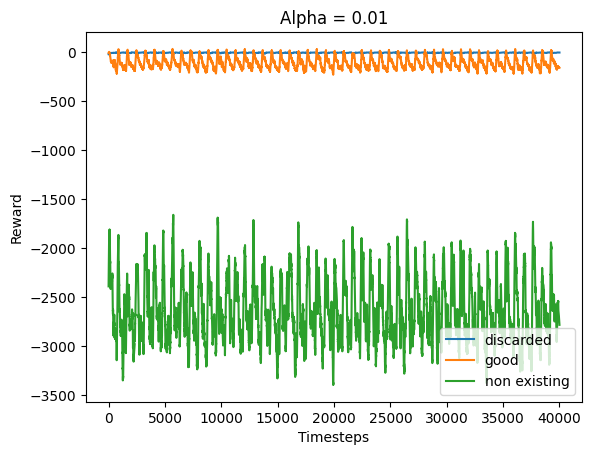

In [129]:
plot_reward(a01, -60, 0.01)

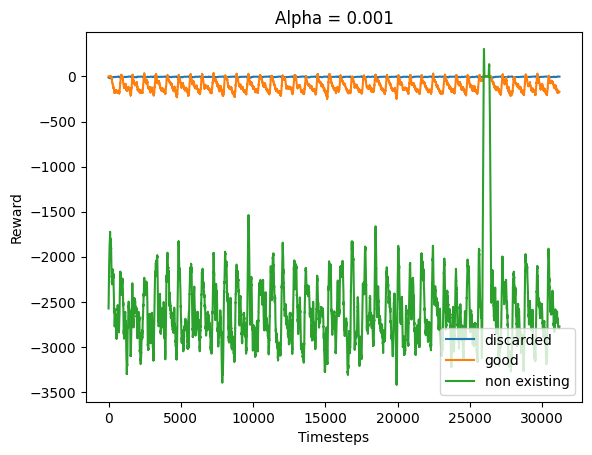

In [131]:
plot_reward(a001, -60, 0.001)

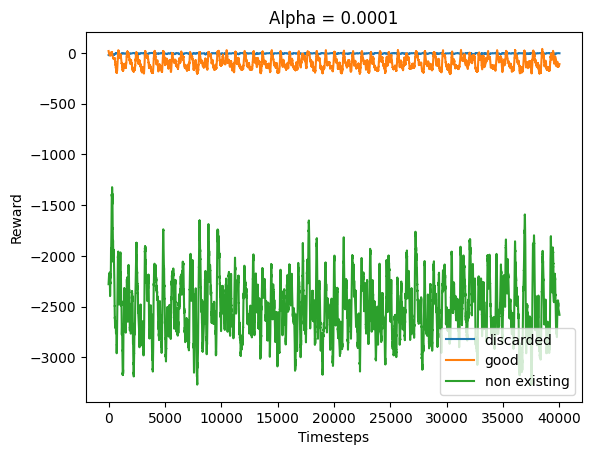

In [132]:
plot_reward(a0001, -60,  0.0001)

### 2 Epsilon decay test

Applied epsilon decay over all episodes as opposed to: within each episode and resetting the epsilon each time.
Decay set to 0.98.
Episode 25: 0.98<sup>25</sup> = 0.603.
Episode 45: 0.98<sup>45</sup> = 0.403

Time: 1:57:29.234508

#### Model
```
input -> [64, relu] -> [32, relu] -> [output, relu]
```
Note: accidentally used RELU activation for output..

Reward for non-existing products: -100
Existing products are not rewarded.


In [5]:
path_ed098 = r'results/request_scratch/epsilon_decay/0.98'
ed098 = read_csv(path_ed098)

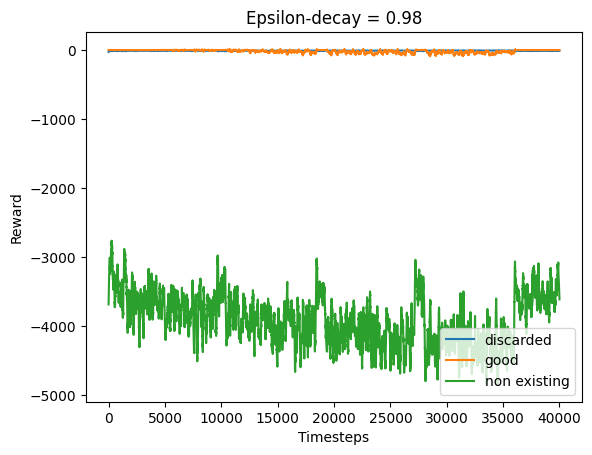

In [135]:
plot_reward(ed098, -100, 0.98)

### 3 Reward shaping

Changed base reward to 50. Non-existing product, reward: -50.

#### Model
```
input -> [64, relu] -> [32, relu] -> [output, linear]
```
Episode = 5 * 365
100 episodes



In [74]:
reward_path = r'results/request_scratch/reward_50/64-32'
reward_df = read_csv(reward_path)

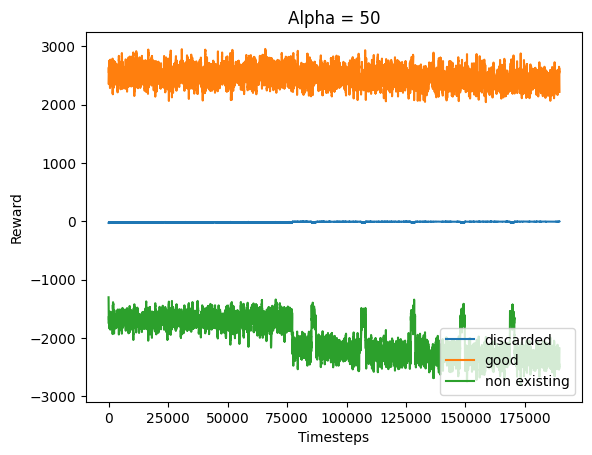

In [133]:
plot_reward(reward_df, -50, 50)